# Spark ML - Binomial Logistic Regression (Adv Example)
Now that you've completed the documentation examples, it's good to go through something a little more complex. This tutorial's materials have been adapted from Susan Li. Find more information here: 
- https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa
- https://github.com/susanli2016/PySpark-and-MLlib.

Objective: We're using a dataset from Kaggle to predict if a client will subscribe to a term deposit. We'll explore the data, visualise it, create a vector, build a model and evaluate it. 

In [1]:
# Section must be included at the beginning of each new notebook. Remember to change the app name.
# If you're using VirtualBox, change the below to '/home/user/spark-2.1.1-bin-hadoop2.7'
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import *
spark = SparkSession.builder.appName('logistic_regression_adv').getOrCreate()

# If you're getting an error with numpy, please type 'sudo pip3 install numpy --user' into the console.
# If you're getting an error with another package, type 'sudo pip3 install PACKAGENAME --user'. 
# Replace PACKAGENAME with the relevant package (such as pandas, etc).
from pyspark.ml.classification import LogisticRegression

# Import data and print schema - columns is another way to view the data's features.
df = spark.read.csv('Datasets/bank_dataset.csv', header=True, inferSchema=True)
df.printSchema()
print(df.columns)

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)

['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit']


## Utilising Pandas
Pandas is a fantastic data manipulation/analysis library. Let's use it here to explore the data. 

Just a note, for most analyses, we have to convert Spark's DataFrame to a Pandas DataFrame (toPandas). 

In [2]:
# Import pandas.
import pandas as pd

# Take the first five rows of data, and visualise.
pd.DataFrame(df.take(5), columns=df.columns)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [3]:
# To visualise the first five columns, simply add transpose. 
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
age,59,56,41,55,54
job,admin.,admin.,technician,services,admin.
marital,married,married,married,married,married
education,secondary,secondary,secondary,secondary,tertiary
default,no,no,no,no,no
balance,2343,45,1270,2476,184
housing,yes,no,yes,yes,no
loan,no,no,no,no,no
contact,unknown,unknown,unknown,unknown,unknown
day,5,5,5,5,5


In [4]:
# We can use group by and count to find out how many data points we have for each class in our predictor. 
df.groupby('deposit').count().toPandas()

,deposit,count
0,no,5873
1,yes,5289


We can use Pandas to generate some nice summary statistics too.

In [5]:
# Using a for loop to find all columns that belong to the integer data type. 
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']

# Selecting the numeric features, generating summary statistics, and converting to a Pandas DataFrame.
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,11162,41.231947679627304,11.913369192215518,18,95
balance,11162,1528.5385235620856,3225.413325946149,-6847,81204
day,11162,15.658036194230425,8.420739541006462,1,31
duration,11162,371.99381831213043,347.12838571630687,2,3881
campaign,11162,2.508421429851281,2.7220771816614824,1,63
pdays,11162,51.33040673714388,108.75828197197717,-1,854
previous,11162,0.8325568894463358,2.292007218670508,0,58


In [6]:
# Now that we've carried out some basic data exploration, let's select the relevant features. Day/month have been excluded as they're irrelevant.
df = df.select('age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit')
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



## Working with Categorical Columns
While continuous features are simple to utilise, what if a feature in your dataset uses the words male and female to describe gender? These categories should be converted to a number so that they can be utilised effectively by Spark.

Let's break this down into multiple steps to make it all clear. First we'll identify the categorical variables, and convert the various categories into numbers. To help visualise this, think about how gender would look in a table. It would normally be in one column, where the row would be either male or female. But now that we've indexed it, it's been split into two columns (male and female), with either a 1 or a 0 as the row input. We now have two columns when we previously had one. We can collapse this back into one column using the one hot encoder (which might look something like this "[0, 1]"). Finally, we can collapse all of the features into a single vector using VectorAssembler. Phew, done!

Note that this is done in an expanded format to avoid ambiguity, but you could simplify this code using a loop if you like. Also, remember that we're using Spark v2.1.1. 

In [7]:
# Import the relevant packages.
from pyspark.ml.feature import (VectorAssembler,VectorIndexer,OneHotEncoder,StringIndexer)

# First create a string indexer which converts every string into a number, such as male = 0 and female = 1.
# A number will be assigned to every category in the column.
job_indexer = StringIndexer(inputCol='job',outputCol='jobIndex')
marital_indexer = StringIndexer(inputCol='marital',outputCol='maritalIndex')
education_indexer = StringIndexer(inputCol='education',outputCol='educationIndex')
default_indexer = StringIndexer(inputCol='default',outputCol='defaultIndex')
housing_indexer = StringIndexer(inputCol='housing',outputCol='housingIndex')
loan_indexer = StringIndexer(inputCol='loan',outputCol='loanIndex')
contact_indexer = StringIndexer(inputCol='contact',outputCol='contactIndex')
poutcome_indexer = StringIndexer(inputCol='poutcome',outputCol='poutcomeIndex')
deposit_indexer = StringIndexer(inputCol='deposit',outputCol='label')

# Now we can one hot encode these numbers. This converts the various outputs into a single vector.
# Multiple columns are collapsed into one. 
# This makes it easier to process when you have multiple classes.
job_encoder = OneHotEncoder(inputCol='jobIndex',outputCol='jobVec')
marital_encoder = OneHotEncoder(inputCol='maritalIndex',outputCol='maritalVec')
education_encoder = OneHotEncoder(inputCol='educationIndex',outputCol='educationVec')
default_encoder = OneHotEncoder(inputCol='defaultIndex',outputCol='defaultVec')
housing_encoder = OneHotEncoder(inputCol='housingIndex',outputCol='housingVec')
loan_encoder = OneHotEncoder(inputCol='loanIndex',outputCol='loanVec')
contact_encoder = OneHotEncoder(inputCol='contactIndex',outputCol='contactVec')
poutcome_encoder = OneHotEncoder(inputCol='poutcomeIndex',outputCol='poutcomeVec')

# And finally, using vector assembler to turn all of these columns into one column (named features).
assembler = VectorAssembler(inputCols=['jobVec','maritalVec','educationVec','defaultVec',
                                       'housingVec','loanVec','contactVec','poutcomeVec',
                                       'age', 'balance', 'duration', 'campaign', 'pdays',
                                       'previous'], outputCol="features")

##### Extra Credit
Looking at the example above, we've taken all of the relevant input variables, indexed them, encoded them and assembled them. But wait, why didn't we have to encode deposit_indexer (our predictor)? Check out the StringIndexer and OneHotEncoder documentation to find out before moving on to Pipelines.

## Pipelines
But we're not done yet! While everything has been setup above, we haven't called the indexer, encoder, or assembler yet. A simple way to do this is to use pipelines, which allow you to specify a set of steps for everything to occur. 

In [8]:
from pyspark.ml import Pipeline

# Then go through our steps. It's essentially sequential to the above.
pipeline = Pipeline(stages=[job_indexer, marital_indexer, education_indexer, default_indexer,
                            housing_indexer, loan_indexer, contact_indexer, poutcome_indexer,
                            deposit_indexer, job_encoder, marital_encoder, education_encoder,
                            default_encoder, housing_encoder, loan_encoder, contact_encoder,
                            poutcome_encoder, assembler])

# Now that we've got a number of steps, let's apply it to the DataFrame.
pipeline_model = pipeline.fit(df)

# Incorporate results into a new DataFrame.
pipe_df = pipeline_model.transform(df)

# Remove all variables other than features and label. 
pipe_df = pipe_df.select('label', 'features')

## Logistic Regression Model
Now that we've created the appropriate columns, let's build the logistic regression model.

In [15]:
from pyspark.ml.classification import LogisticRegression

# Split our data. Note that the new DataFrame is being used.
train_data, test_data = pipe_df.randomSplit([0.7,0.3])
print("Training Dataset Count: " + str(train_data.count()))
print("Test Dataset Count: " + str(test_data.count()))

# Instantiate the model.
lr_model = LogisticRegression(featuresCol='features',labelCol='label')

# Fit the model.
lr_model = lr_model.fit(train_data)

# And evaluate the model using the test data.
results = lr_model.transform(test_data)

Training Dataset Count: 7821
Test Dataset Count: 3341


## Model Evaluation - Creating Better Visualisations
Now that we've trained and evaluated the model, let's use that data to generate a few graphs. For this example, we'll be using matplotlib. Run the code again in case you can't see the graph.

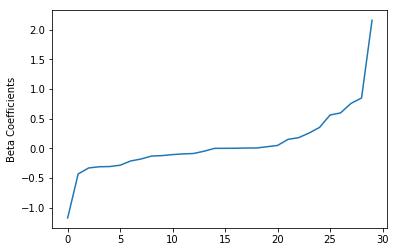

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Visualising the coefficients. Sort from lowest to highest.
beta = np.sort(lr_model.coefficients)

# Plot the data.
plt.plot(beta)

# Add a label to the data.
plt.ylabel('Beta Coefficients')

# Show the graph. 
plt.show()

#### What about ROC and AUC?

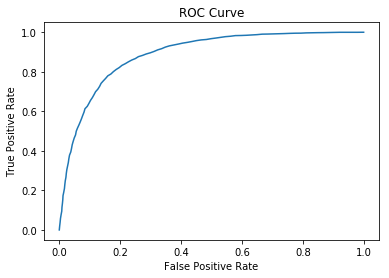

Area Under the Curve: 0.8876958177720394


In [11]:
# Let's get a summary of the data.
training_summary = lr_model.summary

# Convert the DataFrame to a Pandas DataFrame.
ROC = training_summary.roc.toPandas()

# Plot the true positive and false positive rates.
plt.plot(ROC['FPR'],ROC['TPR'])

# Define the labels.
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

# Print the AUC statistic. 
print('Area Under the Curve: ' + str(training_summary.areaUnderROC))

#### Precision and Recall

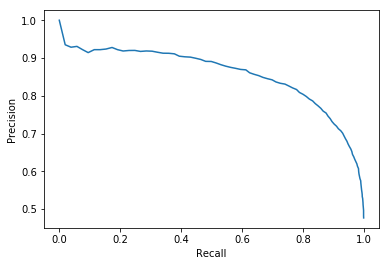

In [12]:
# Convert DataFrame to Pandas DataFrame.
pr = training_summary.pr.toPandas()

# Plot model recall and precision.
plt.plot(pr['recall'],pr['precision'])

# Define the labels and show the graph. 
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()